# RMSProp


我们在 [“Adagrad”](adagrad.md) 一节里提到，由于调整学习率时分母上的变量 $\boldsymbol{s}$ 一直在累加按元素平方的小批量随机梯度，目标函数自变量每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，Adagrad 在迭代后期由于学习率过小，可能较难找到一个有用的解。为了应对这一问题，RMSProp 算法对 Adagrad 做了一点小小的修改 [1]。

下面，我们来描述 RMSProp 算法。


## RMSProp 算法

我们在 [“动量法”](momentum.md) 一节里介绍过指数加权移动平均。事实上，RMSProp 算法使用了小批量随机梯度按元素平方的指数加权移动平均变量 $\boldsymbol{s}$，并将其中每个元素初始化为 0。
给定超参数 $\gamma$ 且 $0 \leq \gamma < 1$，
在每次迭代中，RMSProp 首先计算小批量随机梯度 $\boldsymbol{g}$，然后对该梯度按元素平方项 $\boldsymbol{g} \odot \boldsymbol{g}$ 做指数加权移动平均，记为 $\boldsymbol{s}$：

$$\boldsymbol{s} \leftarrow \gamma \boldsymbol{s} + (1 - \gamma) \boldsymbol{g} \odot \boldsymbol{g}. $$

然后，和 Adagrad 一样，将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：

$$\boldsymbol{g}' \leftarrow \frac{\eta}{\sqrt{\boldsymbol{s} + \epsilon}} \odot \boldsymbol{g}, $$

其中 $\eta$ 是初始学习率且 $\eta > 0$，$\epsilon$ 是为了维持数值稳定性而添加的常数，例如 $10^{-8}$。和 Adagrad 一样，模型参数中每个元素都分别拥有自己的学习率。同样地，最后的自变量迭代步骤与小批量随机梯度下降类似：

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \boldsymbol{g}'. $$


需要强调的是，RMSProp 只在 Adagrad 的基础上修改了变量 $\boldsymbol{s}$ 的更新方法：对平方项 $\boldsymbol{g} \odot \boldsymbol{g}$ 从累加变成了指数加权移动平均。由于变量 $\boldsymbol{s}$ 可看作是最近 $1/(1-\gamma)$ 个时刻的平方项 $\boldsymbol{g} \odot \boldsymbol{g}$ 的加权平均，自变量每个元素的学习率在迭代过程中避免了“直降不升”的问题。


## RMSProp 的实现

RMSProp 的实现很简单。我们只需要把上面的数学公式翻译成代码。

In [1]:
def rmsprop(params, sqrs, lr, gamma, batch_size):
    eps_stable = 1e-8
    for param, sqr in zip(params, sqrs):
        g = param.grad / batch_size
        sqr[:] = gamma * sqr + (1 - gamma) * g.square()
        param[:] -= lr * g / (sqr + eps_stable).sqrt()

## 实验

首先，导入本节中实验所需的包或模块。

In [2]:
import sys
sys.path.append('..')
import gluonbook as gb
from mxnet import autograd, nd
import numpy as np

实验中，我们依然以线性回归为例。设数据集的样本数为 1000，我们使用权重 `w` 为 [2, -3.4]，偏差 `b` 为 4.2 的线性回归模型来生成数据集。该模型的平方损失函数即所需优化的目标函数，模型参数即目标函数自变量。

我们把小批量随机梯度按元素平方的指数加权移动平均变量 $\boldsymbol{s}$ 初始化为和模型参数形状相同的零张量。

In [3]:
# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

# 初始化模型参数。
def init_params():
    w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    sqrs = []
    for param in params:
        param.attach_grad()
        # 把梯度按元素平方的指数加权移动平均变量初始化为和参数形状相同的零张量。
        sqrs.append(param.zeros_like())
    return params, sqrs

优化函数 `optimize` 与 [“Adagrad”](adagrad.md) 一节中的类似。

In [4]:
net = gb.linreg
loss = gb.squared_loss

def optimize(batch_size, lr, gamma, num_epochs, log_interval):
    [w, b], sqrs = init_params()
    ls = [loss(net(features, w, b), labels).mean().asnumpy()]
    for epoch in range(1, num_epochs + 1):
        for batch_i, (X, y) in enumerate(
            gb.data_iter(batch_size, features, labels)):
            with autograd.record():
                l = loss(net(X, w, b), y)
            l.backward()
            rmsprop([w, b], sqrs, lr, gamma, batch_size)
            if batch_i * batch_size % log_interval == 0:
                ls.append(loss(net(features, w, b), labels).mean().asnumpy())
    print('w:', w, '\nb:', b, '\n')
    es = np.linspace(0, num_epochs, len(ls), endpoint=True)
    gb.semilogy(es, ls, 'epoch', 'loss')

我们将初始学习率设为 0.03，并将 $\gamma$（`gamma`）设为 0.9。此时，变量 $\boldsymbol{s}$ 可看作是最近 $1/(1-0.9) = 10$ 个时刻的平方项 $\boldsymbol{g} \odot \boldsymbol{g}$ 的加权平均。我们观察到，损失函数在迭代后期较震荡。

w: 
[[ 2.04485798]
 [-3.40874457]]
<NDArray 2x1 @cpu(0)> 
b: 
[ 4.24133873]
<NDArray 1 @cpu(0)> 



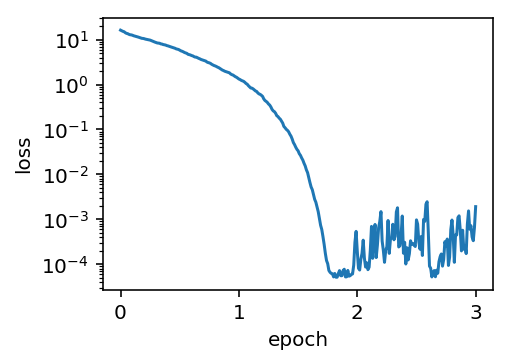

In [5]:
optimize(batch_size=10, lr=0.03, gamma=0.9, num_epochs=3, log_interval=10)

我们将 $\gamma$ 调大一点，例如 0.999。此时，变量 $\boldsymbol{s}$ 可看作是最近 $1/(1-0.999) = 1000$ 个时刻的平方项 $\boldsymbol{g} \odot \boldsymbol{g}$ 的加权平均。这时损失函数在迭代后期较平滑。

w: 
[[ 1.99897313]
 [-3.39926195]]
<NDArray 2x1 @cpu(0)> 
b: 
[ 4.20111752]
<NDArray 1 @cpu(0)> 



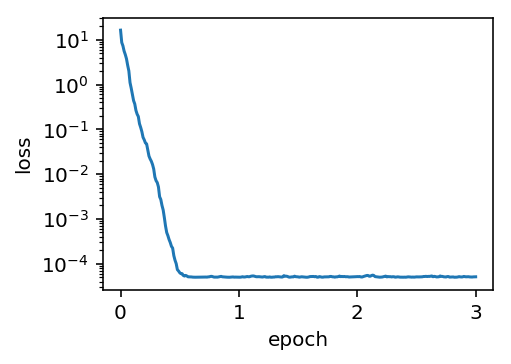

In [6]:
optimize(batch_size=10, lr=0.03, gamma=0.999, num_epochs=3, log_interval=10)

## 小结

* RMSProp 和 Adagrad 的不同在于，RMSProp 使用了小批量随机梯度按元素平方的指数加权移动平均变量来调整学习率。
* 理解指数加权移动平均有助于我们调节 RMSProp 算法中的超参数，例如 $\gamma$。


## 练习

* 把 $\gamma$ 的值设为 0 或 1，观察并分析实验结果。

## 扫码直达 [ 讨论区 ](https://discuss.gluon.ai/t/topic/2275)


![](../img/qr_rmsprop.svg)

## 参考文献

[1] Tieleman, T., & Hinton, G. (2012). Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude. COURSERA: Neural networks for machine learning, 4(2), 26-31.